<a href="https://colab.research.google.com/github/Anam2291/Deep_Learning_Projects/blob/main/Facial_Emotion_Detection_fer2013_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import necessary libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


# **Load the FER-2013 Dataset**

In [2]:
# Install the Kaggle library
!pip install kaggle

# Import necessary libraries
import os
import zipfile

# Set Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d msambare/fer2013

# Extract the dataset
dataset_zip = 'fer2013.zip'
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Dataset extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:03<00:00, 22.8MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.6MB/s]
Dataset extracted successfully!


In [3]:
# Define directories
train_dir = '/content/train'
val_dir = '/content/test'

# **Explore the Dataset and Display Sample Images**

Categories: ['surprise', 'neutral', 'angry', 'fear', 'happy', 'disgust', 'sad']


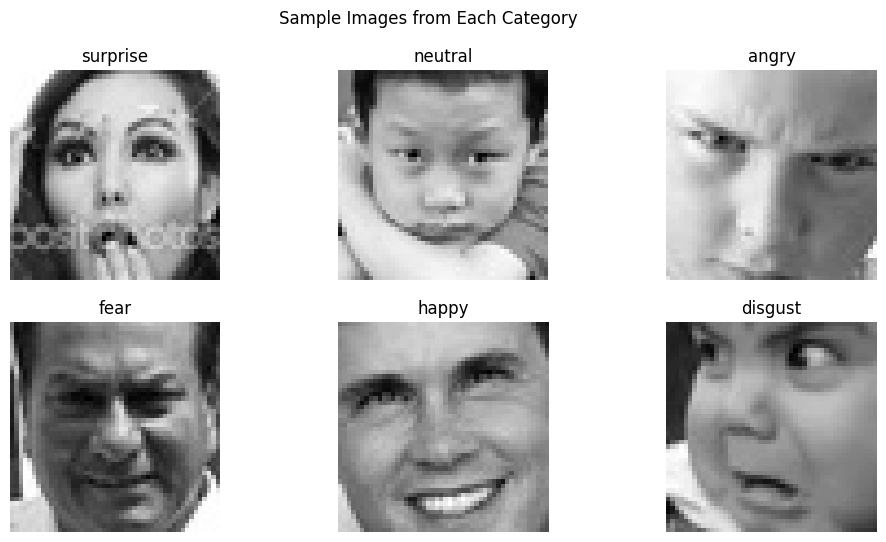

In [4]:
categories = os.listdir(train_dir)
print(f"Categories: {categories}")

plt.figure(figsize=(12, 6))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(train_dir, category)
    image_name = os.listdir(category_path)[0]
    image_path = os.path.join(category_path, image_name)
    img = plt.imread(image_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis('off')
plt.suptitle("Sample Images from Each Category")
plt.show()

# **Data Augmentation and Preprocessing**

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    val_dir,  # This line is causing the error
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


# **Load Pre-trained VGG16 and Modify**

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **Unfreeze the last few layers of the base model**

In [9]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Compile the Model**

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,845 (56.64 MB)

 Trainable params: 7,212,581 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# **Train the Model**

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= 100
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - accuracy: 0.2260 - loss: 1.8659 - val_accuracy: 0.2760 - val_loss: 1.7464
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.2853 - loss: 1.7542 - val_accuracy: 0.3749 - val_loss: 1.6050
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.3177 - loss: 1.7048 - val_accuracy: 0.3720 - val_loss: 1.5852
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.3498 - loss: 1.6548 - val_accuracy: 0.3806 - val_loss: 1.5872
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.3583 - loss: 1.6279 - val_accuracy: 0.4182 - val_loss: 1.4981
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.3745 - loss: 1.5985 - val_accuracy: 0.4301 - val_loss: 1.4771
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.3841 - loss: 1.5815 - val_accuracy: 0.4415 - val_loss: 1.4560
Epoch 8/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4079 - loss: 1.5465 - val_

# **Evaluate the Model**

In [12]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")

898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6841 - loss: 0.8592
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5416 - loss: 1.3899
Training Accuracy: 67.98%, Validation Accuracy: 57.12%


# **Generate Classification Report and Confusion Matrix**

In [13]:
print("Evaluating the model...")
labels = val_generator.classes
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(labels, predicted_classes, target_names=list(val_generator.class_indices.keys())))

print("Confusion Matrix:")
print(confusion_matrix(labels, predicted_classes))

Evaluating the model...
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.51      0.49       958
     disgust       0.74      0.61      0.67       111
        fear       0.49      0.37      0.42      1024
       happy       0.72      0.75      0.74      1774
     neutral       0.49      0.53      0.51      1233
         sad       0.47      0.45      0.46      1247
    surprise       0.67      0.74      0.70       831

    accuracy                           0.57      7178
   macro avg       0.58      0.57      0.57      7178
weighted avg       0.57      0.57      0.57      7178

Confusion Matrix:
[[ 491    6   80   81  128  127   45]
 [  20   68    3    5    4   10    1]
 [ 132    6  383   95  111  191  106]
 [ 101    2   48 1331  153   91   48]
 [ 113    4   80  141  658  178   59]
 [ 155    4  125  130  237  555   41]
 [  31    2   60   58   39   27  614]]


# **Visualize Training History**

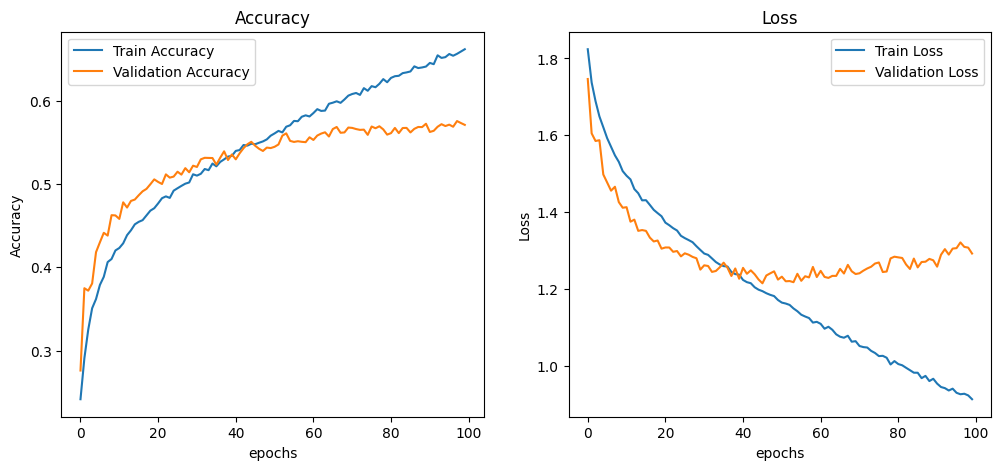

In [14]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

# **Display Model Predictions**

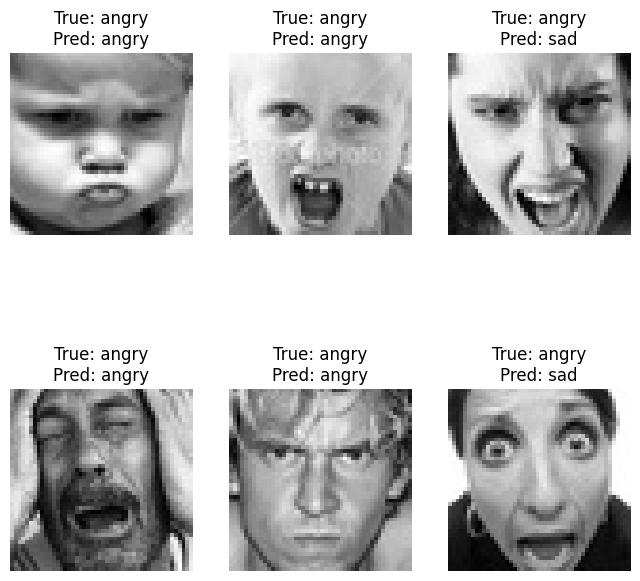

In [19]:
def display_predictions(generator, predictions, labels, num_samples=6):
    """
    Display a few sample images from the validation set along with
    their true labels and predicted labels.
    """
    # Get class labels from the generator
    class_labels = list(generator.class_indices.keys())

    # Display a few images
    plt.figure(figsize=(8, 8))
    count = 0
    for batch_images, batch_labels in generator:
        for i in range(len(batch_images)):
            if count >= num_samples:
                plt.show()
                return

            img = batch_images[i]
            true_label = class_labels[np.argmax(batch_labels[i])]
            predicted_label = class_labels[np.argmax(predictions[count])]

            # Plot the image and labels
            plt.subplot(2, 3, count + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
            count += 1

    plt.show()

# Call the function to display predictions
display_predictions(val_generator, predictions, labels)
